**File name**: main.ipynb<br>
**Authors**: Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt;, Anton Lukashchuk &lt;[academik116@gmail.com](mailto:academik116@gmail.com)&gt;<br>
This file is part of REDE project (https://github.com/akarazeev/REDE)

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
%load_ext autoreload
%autoreload 2

from utils.dataset import REDE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
train_dataset = REDE('data/rede', train=True, transform=torchvision.transforms.ToTensor(),
                     download=True, test_size=0.2)
train_dataset

Processing...
Done!


Dataset REDE
    Number of datapoints: 1478
    Split: train (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x1099c5e10>

In [10]:
test_dataset = REDE('data/rede', train=False, transform=torchvision.transforms.ToTensor(),
                   download=True, test_size=0.2, test_indices=train_dataset.test_indices)
test_dataset

Dataset REDE
    Number of datapoints: 370
    Split: test (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x10b680a58>

In [11]:
BATCH = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

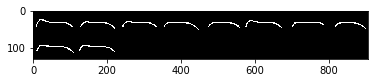

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to show an image.
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, parameters = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))

In [13]:
# Corresponding parameters of simulated models -
# (gap, width1, height, radius1, width2).
parameters


1.00000e-05 *
  0.0400  0.1550  0.0800  2.4000  0.0960
  0.0300  0.1550  0.0750  2.2000  0.0960
  0.0300  0.1450  0.0800  2.3000  0.0920
  0.0350  0.1450  0.0700  1.8000  0.0960
  0.0250  0.1500  0.0700  2.4000  0.0800
  0.0300  0.1550  0.0850  2.0000  0.0960
  0.0400  0.1550  0.0750  2.2000  0.0800
  0.0250  0.1550  0.0700  2.4000  0.0920
  0.0400  0.1450  0.0750  2.0000  0.0960
  0.0400  0.1550  0.0750  1.8000  0.0920
[torch.FloatTensor of size 10x5]

In [14]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 5, stride=2),
            nn.MaxPool2d(5, 1),
            nn.Conv2d(3, 5, 3, stride=1),
            nn.MaxPool2d(3, 1),
            nn.ReLU(True),
            nn.Conv2d(5, 2, 3, stride=1),
            nn.MaxPool2d(2, 2)
        )
        self.head = nn.Linear(396, 5)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x.view(x.size(0), -1))

criterion = nn.MSELoss()

# Train

In [15]:
def test_net(net):
    """Function helps to calculate loss on test dataset."""
    test_loss = 0
    for data in test_loader:
        
        inputs, labels = data
        labels = labels * 1e7

        inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.data[0]
    return test_loss

# Training loop

In [16]:
%%time

EPOCH = 10  # Total number of epochs to train.
LR = 0.0001  # Initial learning rate.

net = Net()
optimizer = optim.Adam(net.parameters(), LR)

print_each = 30  # Print training loss every `print_each` iteration.
test_each = 2    # Print testing loss every `test_each` epoch.
reduce_lr = 4    # Reduce `LR` by 2 every `reduce_lr` epoch.

curtimestep = 0
test_steps = []
test_losses = []
train_steps = []
train_losses = []

for epoch in range(EPOCH):  # Loop over the dataset multiple times.
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] = LR
        
        # Get the inputs.
        inputs, parameters = data
        parameters = parameters * 1e7

        # Wrap them in Variable.
        inputs, parameters = Variable(inputs), Variable(parameters)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward -> backward -> optimize.
        outputs = net(inputs)
        loss = criterion(outputs, parameters)
        loss.backward()
        optimizer.step()
        
        # Add loss per element.
        running_loss += loss.data[0] / len(parameters)
        
        curtimestep += 1
        
        # Print statistics.
        if i % print_each == print_each - 1:
            loss_per_element = running_loss / print_each
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss_per_element))
            
            train_losses.append(loss_per_element)
            train_steps.append(curtimestep)
            running_loss = 0.0

    # Calculate loss on test dataset.
    if epoch % test_each == test_each - 1:
        test_loss = test_net(net)
        test_loss /= len(test_dataset)
        print('[%d] Test loss: %.3f' % (epoch + 1, test_loss))
        print('LR: {}'.format(LR))
        
        test_losses.append(test_loss)
        test_steps.append(curtimestep)
    
    # Reduce LR by 2 every `reduce_lr` epoch.
    if epoch % reduce_lr == reduce_lr - 1:
        LR /= 2.

print('Finished Training')

[1,    30] loss: 892.943
[1,    60] loss: 907.639
[1,    90] loss: 898.684
[1,   120] loss: 900.220
[2,    30] loss: 852.693
[2,    60] loss: 840.837
[2,    90] loss: 794.376
[2,   120] loss: 743.243
[2] Test loss: 596.033
LR: 0.0001
[3,    30] loss: 555.026
[3,    60] loss: 445.326
[3,    90] loss: 307.447
[3,   120] loss: 182.556
[4,    30] loss: 36.213
[4,    60] loss: 17.143
[4,    90] loss: 11.459
[4,   120] loss: 9.654
[4] Test loss: 10.788
LR: 0.0001
[5,    30] loss: 10.943
[5,    60] loss: 10.057
[5,    90] loss: 10.493
[5,   120] loss: 9.491
[6,    30] loss: 10.899
[6,    60] loss: 9.982
[6,    90] loss: 10.443
[6,   120] loss: 9.433
[6] Test loss: 10.744
LR: 5e-05
[7,    30] loss: 10.839
[7,    60] loss: 9.927
[7,    90] loss: 10.397
[7,   120] loss: 9.375
[8,    30] loss: 10.777
[8,    60] loss: 9.871
[8,    90] loss: 10.351
[8,   120] loss: 9.316
[8] Test loss: 10.635
LR: 5e-05
[9,    30] loss: 10.710
[9,    60] loss: 9.818
[9,    90] loss: 10.323
[9,   120] loss: 9.279
[10

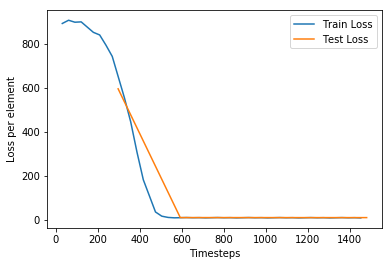

In [17]:
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(test_steps, test_losses, label='Test Loss')
plt.xlabel('Timesteps')
plt.ylabel('Loss per element')
plt.legend()
plt.show()

# Test

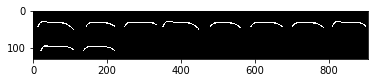

In [18]:
# Get some random testing images.
dataiter = iter(test_loader)
images, parameters = dataiter.next()

# Print images.
imshow(torchvision.utils.make_grid(images))

In [19]:
parameters * 1e7


   2.5000   15.5000    8.5000  180.0000    9.6000
   2.5000   14.5000    7.5000  240.0000    8.0000
   4.0000   15.0000    7.5000  200.0000    8.0000
   3.5000   15.0000    7.5000  180.0000    9.6000
   2.5000   15.5000    7.5000  200.0000    8.4000
   3.5000   14.5000    7.0000  210.0000    8.4000
   3.0000   14.5000    7.0000  240.0000    8.0000
   3.5000   15.0000    8.0000  180.0000    8.4000
   3.5000   15.0000    8.0000  180.0000    8.0000
   3.0000   14.5000    7.5000  200.0000    8.4000
[torch.FloatTensor of size 10x5]

In [20]:
inputs = Variable(images)
outputs = net(inputs)
outputs

Variable containing:
   3.1878   14.8130    7.7425  213.8460    9.6695
   2.8913   14.3568    7.6488  198.5177    8.3187
   3.2177   14.6830    7.4555  204.6153    8.1965
   3.3047   14.8176    7.6961  212.8840    9.5835
   2.8923   14.7750    7.5932  205.4570    8.8629
   3.1564   14.5487    7.4780  206.6520    8.5491
   3.0166   15.0243    7.3524  210.3667    8.9454
   3.2426   14.5079    7.6490  207.6126    8.5079
   3.3398   14.5313    7.7125  208.2065    8.3498
   3.1131   14.6619    7.4911  207.7990    8.6078
[torch.FloatTensor of size 10x5]